# Interpretable Modelling of Credit Risk

As detailed in Cynthia Rudin's excellent commentary on interpretability [(ArXiV version here)](https://arxiv.org/abs/1811.10154), there are a plethora of reasons to avoid the use of black box models when models are being used to make high stakes decisions to may have life-altering effects on real people. Efforts to develop "explainable black box models," while appealing for their potential to let us continuing using the same tools we always have and to creation explanations after the fact, are inherently flawed. As Rudin notes in my single favorite passage from her paper:

> Explainable ML methods provide explanations that are not faithful to what the original model computes. Explanations must be wrong. They cannot have perfect fidelity with respect to the original model. If the explanation was completely faithful to what the original model computes, the explanation would equal the original model, and one would not need the original model in the first place, only the explanation. (In other words, this is a case where the original model would be interpretable.) This leads to the danger that any explanation method for a black box model can be an inaccurate representation of the original model in parts of the feature space.
>
> An inaccurate (low-fidelity) explanation model limits trust in the explanation, and by extension, trust in the black box that it is trying to explain. An explainable model that has a 90% agreement with the original model indeed explains the original model most of the time. However, an explanation model that is correct 90% of the time is wrong 10% of the time. If a tenth of the explanations are incorrect, one cannot trust the explanations, and thus one cannot trust the original black box. If we cannot know for certain whether our explanation is correct, we cannot know whether to trust either the explanation or the original model.

With this motivation in mind, in this exercise, we will use a cutting edge interpretable modeling framework to model credit risk using data from the [14th Pacific-Asia Knowledge Discovery and Data Mining conference (PAKDD 2010)](https://pakdd.org/archive/pakdd2010/). This data covers the period of 2006 to 2009, and "comes from a private label credit card operation of a Brazilian credit company and its partner shops." (The competition was won by [TIMi](https://timi.eu/blog/news/timi-top-winner-at-the-pakdd-2010-cup/), who purely by coincidence helped me complete my PhD dissertation research!).

We will be working with Generalized Additive Models (GAMs) (not to be confused with Generalized *Linear* Models (GLMs) — GLMs are a special case of GAMs). In particular, we will be using the [pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html), though this is far from the only GAM implementation out there. [mvgam](https://nicholasjclark.github.io/mvgam/) in R is probably considered the gold standard, as it was developed by a pioneering researcher of GAMs. `statsmodels` also has [an implementation](https://www.statsmodels.org/stable/gam.html), and GAM is also hiding in plain sight behind many other tools, like Meta's [Prophet](https://facebook.github.io/prophet/) time series forecasting library (which is GAM-based).

## Data Prep

### Exercise 1

The PADD 2010 data is in [this repository](https://github.com/nickeubank/MIDS_Data/tree/master/PAKDD%202010). You can find column names in `PAKDD2010_VariablesList.XLS` and the actual data in `PAKDD2010_Modeling_Data.txt`.

Note: you may run into a string-encoding issue loading the `PAKDD2010_Modeling_Data.txt` data. All I'll say is that most latin-based languages used `latin8` as a text encoding prior to broad adoption of UTF-8. (Don't know about UTF? [Check out this video](https://www.youtube.com/watch?v=MijmeoH9LT4)!)

Load the data (including column names).

In [211]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import warnings

# Ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

# Set file path and name
path = "https://github.com/nickeubank/MIDS_Data/raw/master/PAKDD%202010/"
file_name = "PAKDD2010_Modeling_Data.txt"

In [212]:
column_names = [
    "ID_CLIENT",
    "CLERK_TYPE",
    "PAYMENT_DAY",
    "APPLICATION_SUBMISSION_TYPE",
    "QUANT_ADDITIONAL_CARDS",
    "POSTAL_ADDRESS_TYPE",
    "SEX",
    "MARITAL_STATUS",
    "QUANT_DEPENDANTS",
    "EDUCATION_LEVEL1",
    "STATE_OF_BIRTH",
    "CITY_OF_BIRTH",
    "NACIONALITY",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "FLAG_RESIDENCIAL_PHONE",
    "RESIDENCIAL_PHONE_AREA_CODE",
    "RESIDENCE_TYPE",
    "MONTHS_IN_RESIDENCE",
    "FLAG_MOBILE_PHONE",
    "FLAG_EMAIL",
    "PERSONAL_MONTHLY_INCOME",
    "OTHER_INCOMES",
    "FLAG_VISA",
    "FLAG_MASTERCARD",
    "FLAG_DINERS",
    "FLAG_AMERICAN_EXPRESS",
    "FLAG_OTHER_CARDS",
    "QUANT_BANKING_ACCOUNTS",
    "QUANT_SPECIAL_BANKING_ACCOUNTS",
    "PERSONAL_ASSETS_VALUE",
    "QUANT_CARS",
    "COMPANY",
    "PROFESSIONAL_STATE",
    "PROFESSIONAL_CITY",
    "PROFESSIONAL_BOROUGH",
    "FLAG_PROFESSIONAL_PHONE",
    "PROFESSIONAL_PHONE_AREA_CODE",
    "MONTHS_IN_THE_JOB",
    "PROFESSION_CODE",
    "OCCUPATION_TYPE",
    "MATE_PROFESSION_CODE",
    "EDUCATION_LEVEL2",
    "FLAG_HOME_ADDRESS_DOCUMENT",
    "FLAG_RG",
    "FLAG_CPF",
    "FLAG_INCOME_PROOF",
    "PRODUCT",
    "FLAG_ACSP_RECORD",
    "AGE",
    "RESIDENCIAL_ZIP_3",
    "PROFESSIONAL_ZIP_3",
    "TARGET_LABEL_BAD",
]

# Load the data
model_data = pd.read_csv(
    path + file_name, header=None, delimiter="\t", encoding="latin1"
)
# Set the column names
model_data.columns = column_names

# Display the first 5 rows of the dataframe
model_data.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL1,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


### Exercise 2

There are a few variables with a lot of missing values (more than half missing). Given the limited documentation for this data it's a little hard to be sure why, but given the effect on sample size and what variables are missing, let's go ahead and drop them. You you end up dropping 6 variables.

Hint: Some variables have missing values that aren't immediately obviously.

(This is not strictly necessary at this stage, given we'll be doing more feature selection down the line, but keeps things easier knowing we don't have to worry about missingness later.)

In [213]:
# Display the shape of the dataframe
model_data.shape

(50000, 54)

In [214]:
# Get Column names and types
def get_column_names_and_types(df):
    columns_and_types = pd.DataFrame(df.dtypes).reset_index()
    columns_and_types.columns = ["Column Name", "Data Type"]

    return columns_and_types

column_names_types = get_column_names_and_types(model_data)
column_names_types

,Column Name,Data Type
0,ID_CLIENT,int64
1,CLERK_TYPE,object
2,PAYMENT_DAY,int64
3,APPLICATION_SUBMISSION_TYPE,object
4,QUANT_ADDITIONAL_CARDS,int64
5,POSTAL_ADDRESS_TYPE,int64
6,SEX,object
7,MARITAL_STATUS,int64
8,QUANT_DEPENDANTS,int64
9,EDUCATION_LEVEL1,int64


In [215]:
# Get the columns and their missing values percentage
def missing_values_percentage(df):
    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().mean() * 100

    # Filter columns with missing percentage greater than 0
    missing_percentage = missing_percentage[missing_percentage > 0]
    
    # Convert to DataFrame for better readability
    missing_percentage_df = missing_percentage.reset_index()
    missing_percentage_df.columns = ["Column", "MissingPercentage"]

    # Sort the DataFrame by MissingPercentage in descending order
    missing_percentage_df = missing_percentage_df.sort_values(
        by="MissingPercentage", ascending=False
    )

    return missing_percentage_df

missing_df = missing_values_percentage(model_data)
missing_df

,Column,MissingPercentage
2,PROFESSIONAL_CITY,67.566
3,PROFESSIONAL_BOROUGH,67.566
7,EDUCATION_LEVEL2,64.676
6,MATE_PROFESSION_CODE,57.768
4,PROFESSION_CODE,15.512
5,OCCUPATION_TYPE,14.626
1,MONTHS_IN_RESIDENCE,7.554
0,RESIDENCE_TYPE,2.698


In [216]:
# # get unique values for columns
# def get_unique_values(df, col_name):
#     """Returns the unique values for a specific column in a DataFrame."""
#     unique_values = df[col_name].unique()
#     return unique_values


# # Loop over all columns and print their unique values
# for col_name in model_data.columns:
#     unique_values = get_unique_values(model_data, col_name)
#     print(f"Unique values in '{col_name}': {unique_values}")

In [217]:
# Set columns to drop
columns_to_drop = [
    "PROFESSIONAL_CITY",
    "PROFESSIONAL_BOROUGH",
    "EDUCATION_LEVEL1",
    "EDUCATION_LEVEL2",
    "MATE_PROFESSION_CODE",
    "PROFESSION_CODE",
]

# Drop the columns from the DataFrame
model_data = model_data.drop(columns=columns_to_drop, errors="ignore")
model_data.shape

(50000, 48)

### Exercise 3

Let's start off by fitting a model that uses the following variables:

```
"QUANT_DEPENDANTS",
"QUANT_CARS",
"MONTHS_IN_RESIDENCE",
"PERSONAL_MONTHLY_INCOME",
"QUANT_BANKING_ACCOUNTS",
"AGE",
"SEX",
"MARITAL_STATUS",
"OCCUPATION_TYPE",
"RESIDENCE_TYPE",
"RESIDENCIAL_STATE",
"RESIDENCIAL_CITY",
"RESIDENCIAL_BOROUGH",
"RESIDENCIAL_ZIP_3"
```

(GAMs don't have any automatic feature selection methods, so these are based on my own sense of features that are likely to matter. A fully analysis would entail a few passes at feature refinement)

Plot and otherwise characterize the distributions of all the variables we may use. If you see anything bananas, adjust how terms enter your model. Yes, pyGAM has flexible functional forms, but giving the model features that are engineered to be more substantively meaningful (e.g., taking log of income) will aid model estimation. 

You should probably do something about the functional form of *at least* `PERSONAL_MONTHLY_INCOME`, and `QUANT_DEPENDANTS`.

In [218]:
# Set model variables
model_variables = [
    "QUANT_DEPENDANTS",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "PERSONAL_MONTHLY_INCOME",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "RESIDENCIAL_ZIP_3",
    "TARGET_LABEL_BAD",
]

# Filter the DataFrame to include only the model variables
model_data = model_data[model_variables]
model_data.sample(10)

,QUANT_DEPENDANTS,QUANT_CARS,MONTHS_IN_RESIDENCE,PERSONAL_MONTHLY_INCOME,QUANT_BANKING_ACCOUNTS,AGE,SEX,MARITAL_STATUS,OCCUPATION_TYPE,RESIDENCE_TYPE,RESIDENCIAL_STATE,RESIDENCIAL_CITY,RESIDENCIAL_BOROUGH,RESIDENCIAL_ZIP_3,TARGET_LABEL_BAD
49840,3,1,1.0,261.0,1,35,F,2,2.0,1.0,RS,Cachoeirinha,Vila Vista alegre,949,0
23295,0,1,8.0,350.0,0,75,F,1,1.0,1.0,BA,CANAVIEIRAS,CENTRO,458,0
46633,0,1,22.0,350.0,1,62,F,2,1.0,1.0,SP,Sao Paulo,Vila Rosaria,802,1
15634,2,1,15.0,350.0,1,41,F,2,4.0,1.0,CE,Fortaleza,PLANALTO AIRTON SENA,607,1
6388,0,0,10.0,990.0,0,37,F,2,2.0,1.0,MG,UBA,SOBRADINHO,365,0
15835,0,0,22.0,661.0,0,61,M,4,1.0,1.0,BA,JUAZEIRO,CENTRO,489,0
22875,1,1,0.0,350.0,1,40,M,1,2.0,1.0,BA,SALVADOR,NORDESTE DE AMARALINA,419,1
10836,3,1,6.0,800.0,1,28,F,2,4.0,1.0,SP,IG DO TIETE,CDHU,173,0
40226,0,0,NaN,397.0,0,23,F,1,NaN,1.0,PE,Jaboatao dos Guararapes,Prazeres,543,1
37713,0,0,NaN,215.0,0,37,F,1,2.0,1.0,RS,DOM PEDRITO,SAO GREGORIO,964,0


In [219]:
# Summary statistics for numerical columns
summary_stats = model_data.describe()

summary_stats

,QUANT_DEPENDANTS,QUANT_CARS,MONTHS_IN_RESIDENCE,PERSONAL_MONTHLY_INCOME,QUANT_BANKING_ACCOUNTS,AGE,MARITAL_STATUS,OCCUPATION_TYPE,RESIDENCE_TYPE,TARGET_LABEL_BAD
count,50000.000000,50000.000000,46223.000000,50000.000000,50000.000000,50000.00000,50000.00000,42687.000000,48651.000000,50000.000000
mean,0.650520,0.336140,9.727149,886.678437,0.357840,43.24852,2.14840,2.484316,1.252225,0.260820
std,1.193655,0.472392,10.668841,7846.959327,0.479953,14.98905,1.32285,1.532261,0.867833,0.439086
min,0.000000,0.000000,0.000000,60.000000,0.000000,6.00000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,360.000000,0.000000,31.00000,1.00000,1.000000,1.000000,0.000000
50%,0.000000,0.000000,6.000000,500.000000,0.000000,41.00000,2.00000,2.000000,1.000000,0.000000
75%,1.000000,1.000000,15.000000,800.000000,1.000000,53.00000,2.00000,4.000000,1.000000,1.000000
max,53.000000,1.000000,228.000000,959000.000000,2.000000,106.00000,7.00000,5.000000,5.000000,1.000000


In [220]:
# Log transformation of 'PERSONAL_MONTHLY_INCOME'
model_data["LOG_PERSONAL_MONTHLY_INCOME"] = np.log1p(
    model_data["PERSONAL_MONTHLY_INCOME"]
)

# Capping 'QUANT_DEPENDANTS'
cap_threshold = model_data["QUANT_DEPENDANTS"].quantile(
    0.99
)  # Cap at the 99th percentile
model_data["CAPPED_QUANT_DEPENDANTS"] = model_data["QUANT_DEPENDANTS"].clip(
    upper=cap_threshold
)

# Imputing missing values with the median
model_data["MONTHS_IN_RESIDENCE"].fillna(
    model_data["MONTHS_IN_RESIDENCE"].median(), inplace=True
)
model_data["OCCUPATION_TYPE"].fillna(
    model_data["OCCUPATION_TYPE"].median(), inplace=True
)
model_data["RESIDENCE_TYPE"].fillna(model_data["RESIDENCE_TYPE"].median(), inplace=True)

In [221]:
# Summary statistics for categorical columns
summary_stats_categorical = model_data.describe(include=["object", "category"])

summary_stats_categorical

,SEX,RESIDENCIAL_STATE,RESIDENCIAL_CITY,RESIDENCIAL_BOROUGH,RESIDENCIAL_ZIP_3
count,50000,50000,50000,50000,50000
unique,4,27,3529,14511,1481
top,F,SP,Sao Paulo,CENTRO,960
freq,30805,8773,894,4169,721


In [222]:
# Get unique values for SEX column
def get_unique_values(df, column):
    unique_values = df[column].unique()
    return unique_values.tolist()

u_values = get_unique_values(model_data, "SEX")
print(u_values)

['F', 'M', 'N', ' ']


In [223]:
def clean_sex_column(df, column):
    # Replace missing with NaN or a specific value
    df[column].replace(" ", np.nan, inplace=True)
    df[column].replace("N", np.nan, inplace=True)

    # Now get the unique values without the blanks or 'N' values
    unique_values = df[column].unique()

    return unique_values.tolist()


# Usage
u_values_cleaned = clean_sex_column(model_data,'SEX')
print(u_values_cleaned)

['F', 'M', nan]


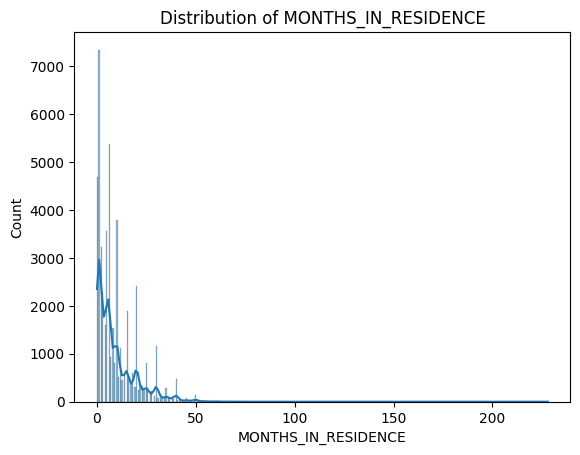

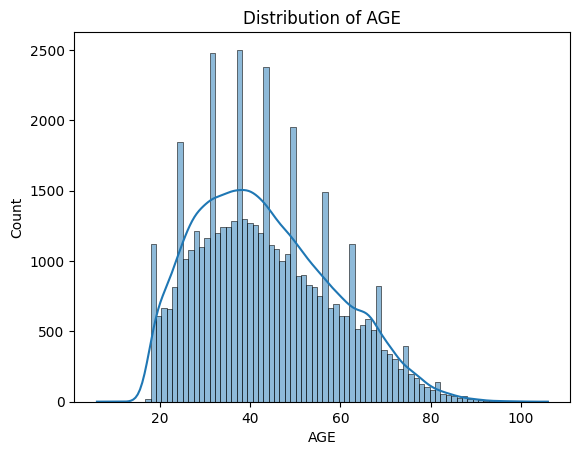

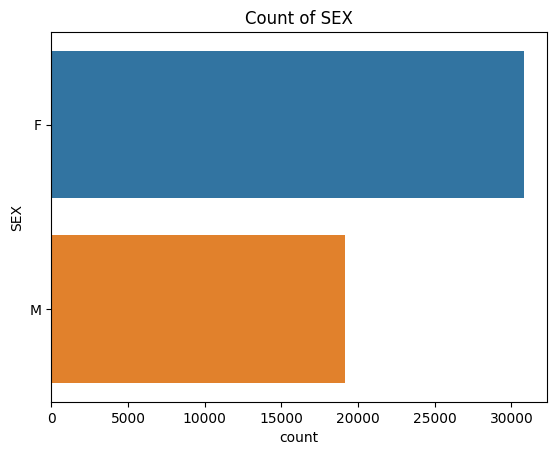

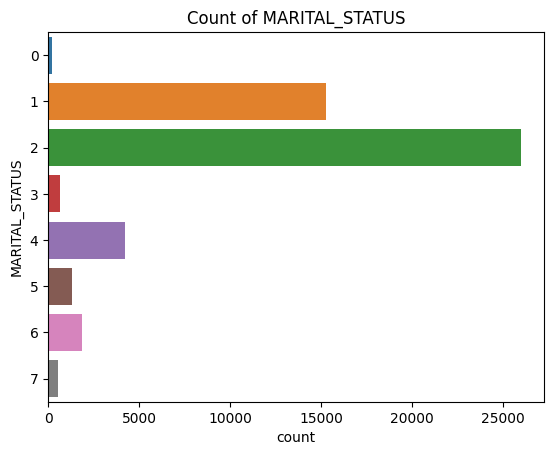

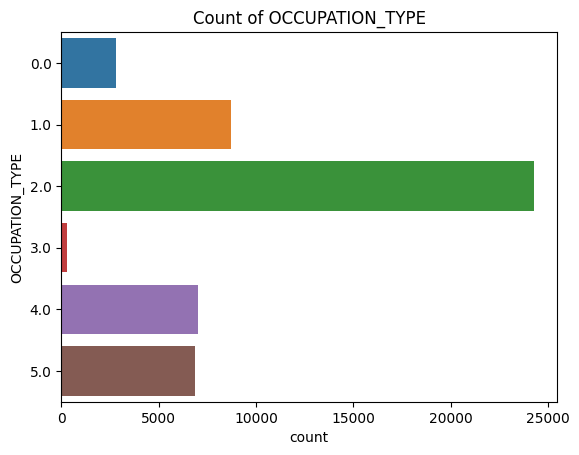

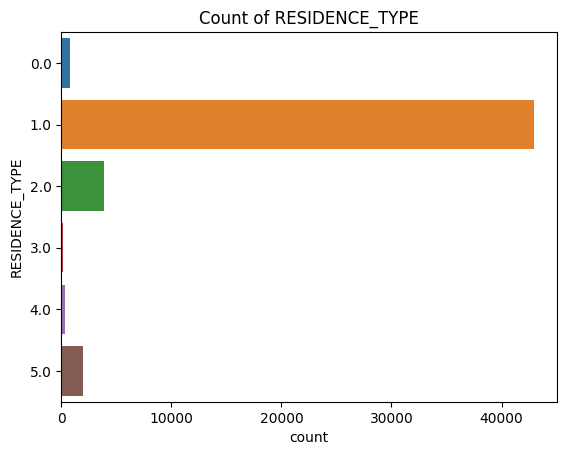

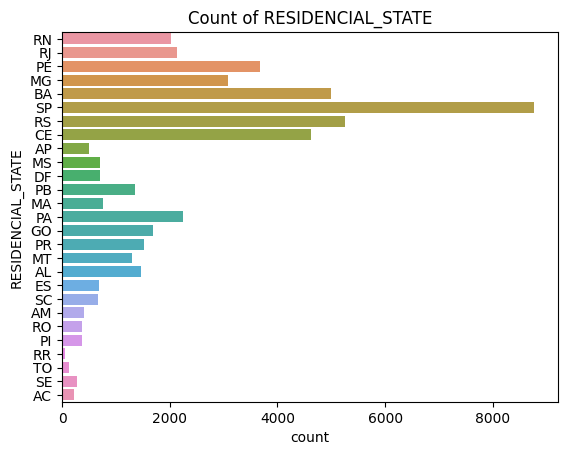

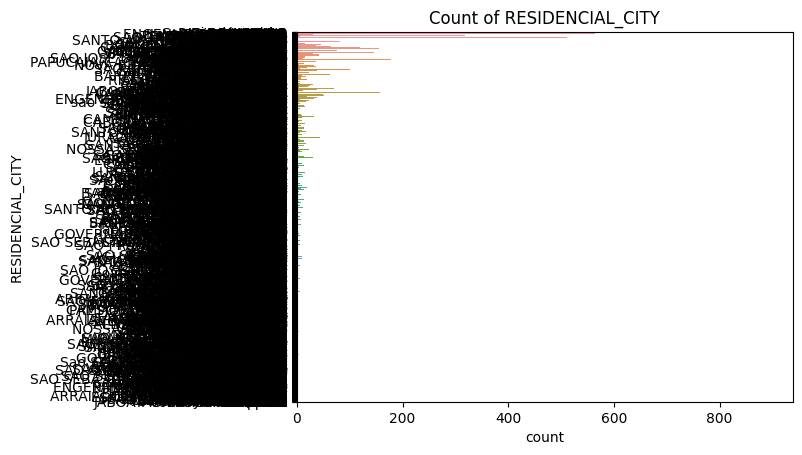

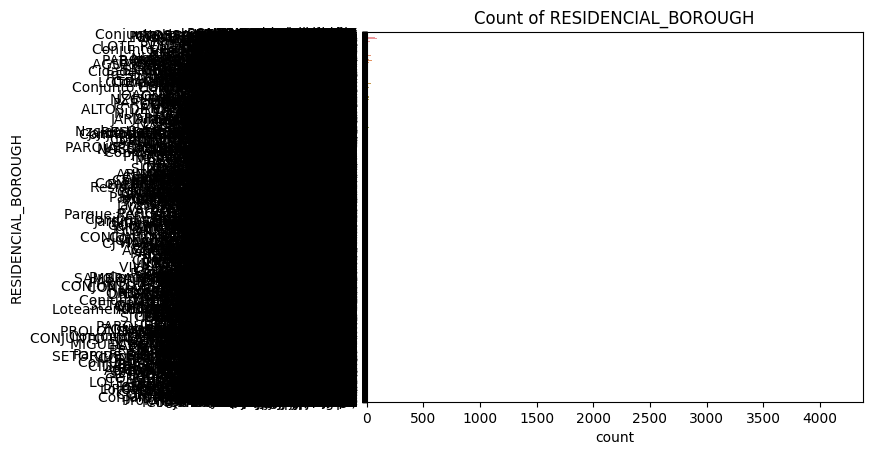

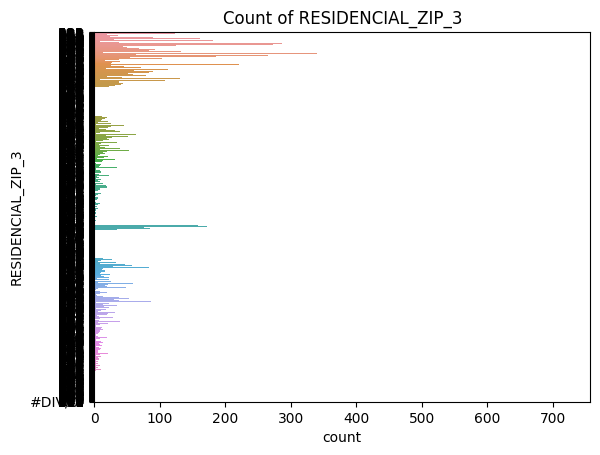

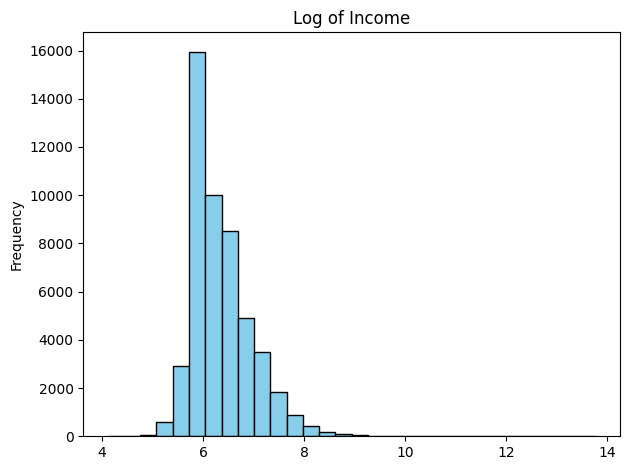

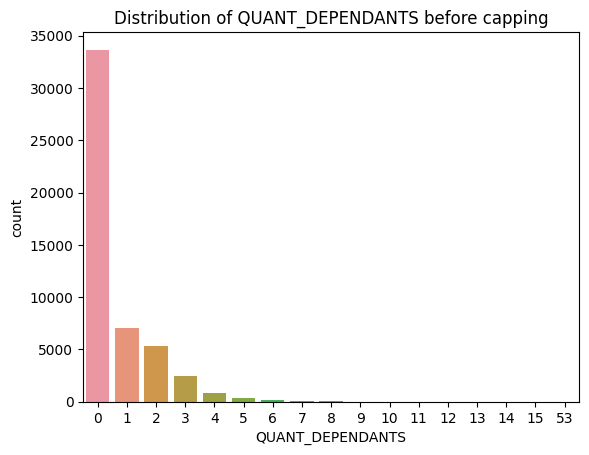

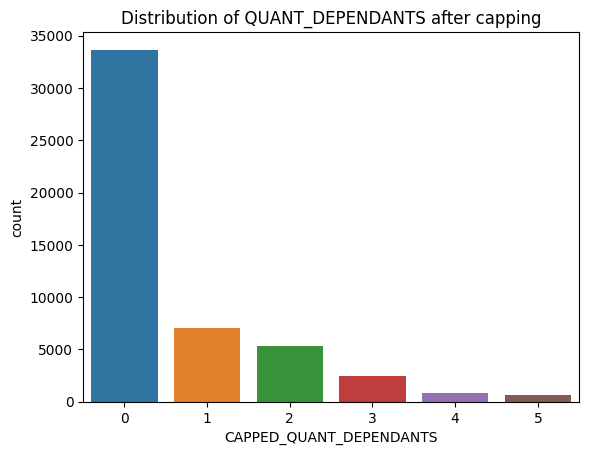

In [224]:
import seaborn as sns

# Histograms for continuous variables
continuous_vars = ["MONTHS_IN_RESIDENCE", "AGE"]
for var in continuous_vars:
    sns.histplot(model_data[var], kde=True)
    plt.title(f"Distribution of {var}")
    plt.show()

# Bar chart for categorical variables
categorical_vars = [
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "RESIDENCIAL_ZIP_3",
    "TARGET_LABEL_BAD",
]
for var in categorical_vars:
    sns.countplot(y=model_data[var])
    plt.title(f"Count of {var}")
    plt.show()

# Histograms for Log of Income
fig, ax = plt.subplots()
ax.hist(
    model_data["LOG_PERSONAL_MONTHLY_INCOME"],
    bins=30,
    color="skyblue",
    edgecolor="black",
)
ax.set_title("Log of Income")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Plot the distribution of QUANT_DEPENDANTS before capping
sns.countplot(x="QUANT_DEPENDANTS", data=model_data)
plt.title("Distribution of QUANT_DEPENDANTS before capping")
plt.show()

# Plot the distribution of QUANT_DEPENDANTS after capping
sns.countplot(x="CAPPED_QUANT_DEPENDANTS", data=model_data)
plt.title("Distribution of QUANT_DEPENDANTS after capping")
plt.show()

In [225]:
values = [6,7,8,9, 10, 11, 12, 13, 14, 15, 53]
for i in range(len(values)):
    print(values[i], ":", model_data[model_data["QUANT_DEPENDANTS"] == values[i]].shape[0])

6 : 139
7 : 65
8 : 35
9 : 14
10 : 13
11 : 7
12 : 6
13 : 4
14 : 3
15 : 1
53 : 1


In [226]:
model_data.head()

,QUANT_DEPENDANTS,QUANT_CARS,MONTHS_IN_RESIDENCE,PERSONAL_MONTHLY_INCOME,QUANT_BANKING_ACCOUNTS,AGE,SEX,MARITAL_STATUS,OCCUPATION_TYPE,RESIDENCE_TYPE,RESIDENCIAL_STATE,RESIDENCIAL_CITY,RESIDENCIAL_BOROUGH,RESIDENCIAL_ZIP_3,TARGET_LABEL_BAD,LOG_PERSONAL_MONTHLY_INCOME,CAPPED_QUANT_DEPENDANTS
0,1,0,15.0,900.0,0,32,F,6,4.0,1.0,RN,Santana do Matos,Centro,595,1,6.803505,1
1,0,0,1.0,750.0,0,34,F,2,4.0,1.0,RJ,RIO DE JANEIRO,CAMPO GRANDE,230,1,6.621406,0
2,0,0,6.0,500.0,0,27,F,2,2.0,1.0,RN,Parnamirim,Boa Esperanca,591,0,6.216606,0
3,0,0,6.0,500.0,0,61,F,2,2.0,1.0,PE,CABO,PONTE DOS CARVALHOS,545,0,6.216606,0
4,0,0,12.0,1200.0,0,48,M,2,5.0,1.0,RJ,Rio de Janeiro,Santa Cruz,235,1,7.090910,0


### Exercise 4

Geographic segregation means residency data often contains LOTS of information. But there's a problem with `RESIDENCIAL_CITY` and `RESIDENCIAL_BOROUGH`. What is the problem?

In any real project, this would be something absolutely worth resolving, but for this exercise, we'll just drop all three string `RESIDENCIAL_` variables.

#### Answer

The issue with `RESIDENCIAL_CITY`, `RESIDENCIAL_BOROUGH` and `RESIDENCIAL_STATE`  is that they can lead to a high dimensionality problem when preparing the data for modeling, especially if many unique cities or boroughs are present. 

This is commonly referred to as the **curse of dimensionality.**

When each city or borough is encoded into a separate categorical variable (e.g., through one-hot encoding), the number of input features can become very large, which may:

1. Increase the complexity of the model.
2. Make the model training process much slower.
3. Require a larger amount of data to train the model effectively.
4. Increase the risk of overfitting, as the model may learn noise in the training data rather than the actual signal.
5. Make interpretation of the model more difficult.

Furthermore, geographic data can sometimes be too granular and specific, which might not generalize well to new, unseen data. It can also inadvertently introduce bias if the model starts making decisions based on location that are not relevant to the problem at hand.

In [227]:
# Dropping the string 'RESIDENCIAL_' variables
model_data.drop(
    ["RESIDENCIAL_STATE", "RESIDENCIAL_CITY", "RESIDENCIAL_BOROUGH"],
    axis=1,
    inplace=True,
)

In [228]:
# get unique values for columns
def get_unique_values(df, col_name):
    """Returns the unique values for a specific column in a DataFrame."""
    unique_values = df[col_name].unique()
    return unique_values


# Loop over all columns and print their unique values
for col_name in model_data.columns:
    unique_values = get_unique_values(model_data, col_name)
    print(f"Unique values in '{col_name}': {unique_values}")

Unique values in 'QUANT_DEPENDANTS': [ 1  0  2  3  4  5  6  7 10  8 13 11  9 12 14 15 53]
Unique values in 'QUANT_CARS': [0 1]
Unique values in 'MONTHS_IN_RESIDENCE': [ 15.   1.   6.  12.   4.   0.   5.  10.   2.   3.  18.  25.  14.  16.
   8.   7.  20.   9.  17.  30.  11.  37.  22.  33.  26.  40.  32.  29.
  23.  13.  36.  45.  60.  34.  21.  31.  35.  38.  39.  24.  19.  48.
  28.  52.  49.  46.  27.  42.  62.  51.  82.  44.  68.  71.  50.  47.
  41.  57.  69.  55. 200.  53. 100.  72.  43.  70.  54.  56.  80.  65.
  90.  58.  96.  64.  76.  84.  73.  59. 228.  63. 101.  99.  66.  67.
  78.  61.  81.  89.]
Unique values in 'PERSONAL_MONTHLY_INCOME': [ 900.    750.    500.   ...  234.25 1443.27  719.38]
Unique values in 'QUANT_BANKING_ACCOUNTS': [0 1 2]
Unique values in 'AGE': [ 32  34  27  61  48  40  28  31  41  36  29  19  49  58  69  39  42  47
  30  26  60  45  56  71  38  53  79  22  37  55  25  67  21  50  51  84
  43  44  57  33  20  63  62  24  54  64  92  65  73  91  35  76  

In [229]:
# Check for missing values in the 'SEX' column
missing_sex = model_data["SEX"].isnull().sum()
print(f"Missing values in SEX column: {missing_sex}")

Missing values in SEX column: 65


In [230]:
# Fill missing values with mode
sex_mode = model_data["SEX"].mode()[0]
model_data["SEX"].fillna(sex_mode, inplace=True)

# Encoding 'SEX' as a binary variable

model_data["SEX"] = model_data["SEX"].astype("category").cat.codes

In [231]:
# Get column names and types
column_names_types = get_column_names_and_types(model_data)
column_names_types

,Column Name,Data Type
0,QUANT_DEPENDANTS,int64
1,QUANT_CARS,int64
2,MONTHS_IN_RESIDENCE,float64
3,PERSONAL_MONTHLY_INCOME,float64
4,QUANT_BANKING_ACCOUNTS,int64
5,AGE,int64
6,SEX,int8
7,MARITAL_STATUS,int64
8,OCCUPATION_TYPE,float64
9,RESIDENCE_TYPE,float64


In [232]:
# Get data where RESIDENCIAL_ZIP_3 = 0
res_zip_3_odd = model_data[model_data["RESIDENCIAL_ZIP_3"] == "#DIV/0!"]
res_zip_3_odd

# Replace '#DIV/0!' with NaN for conversion
model_data['RESIDENCIAL_ZIP_3'] = model_data['RESIDENCIAL_ZIP_3'].replace('#DIV/0!', np.nan)

# Convert the column to numeric, now that '#DIV/0!' has been handled
model_data['RESIDENCIAL_ZIP_3'] = pd.to_numeric(model_data['RESIDENCIAL_ZIP_3'], errors='coerce')

# Calculate the mode; mode() returns a Series, so select the first entry with [0]
res_zip_3_mode = model_data["RESIDENCIAL_ZIP_3"].mode()[0]

# Replace NaN values with the mode
model_data["RESIDENCIAL_ZIP_3"] = model_data["RESIDENCIAL_ZIP_3"].fillna(res_zip_3_mode)

In [233]:
# List of columns to convert to integers
columns_to_convert = [
    "QUANT_DEPENDANTS",
    "CAPPED_QUANT_DEPENDANTS",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "QUANT_BANKING_ACCOUNTS",
    "SEX",
    "TARGET_LABEL_BAD",
    "AGE",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_ZIP_3",
]

# Convert columns to int64, handling missing values if necessary
for column in columns_to_convert:
    
    model_data[column] = model_data[column].astype(int)

# Drop NA values
# model_data = model_data.dropna(inplace=True)

# Confirm changes
print(model_data.dtypes)

QUANT_DEPENDANTS                 int32
QUANT_CARS                       int32
MONTHS_IN_RESIDENCE              int32
PERSONAL_MONTHLY_INCOME        float64
QUANT_BANKING_ACCOUNTS           int32
AGE                              int32
SEX                              int32
MARITAL_STATUS                   int32
OCCUPATION_TYPE                  int32
RESIDENCE_TYPE                   int32
RESIDENCIAL_ZIP_3                int32
TARGET_LABEL_BAD                 int32
LOG_PERSONAL_MONTHLY_INCOME    float64
CAPPED_QUANT_DEPENDANTS          int32
dtype: object


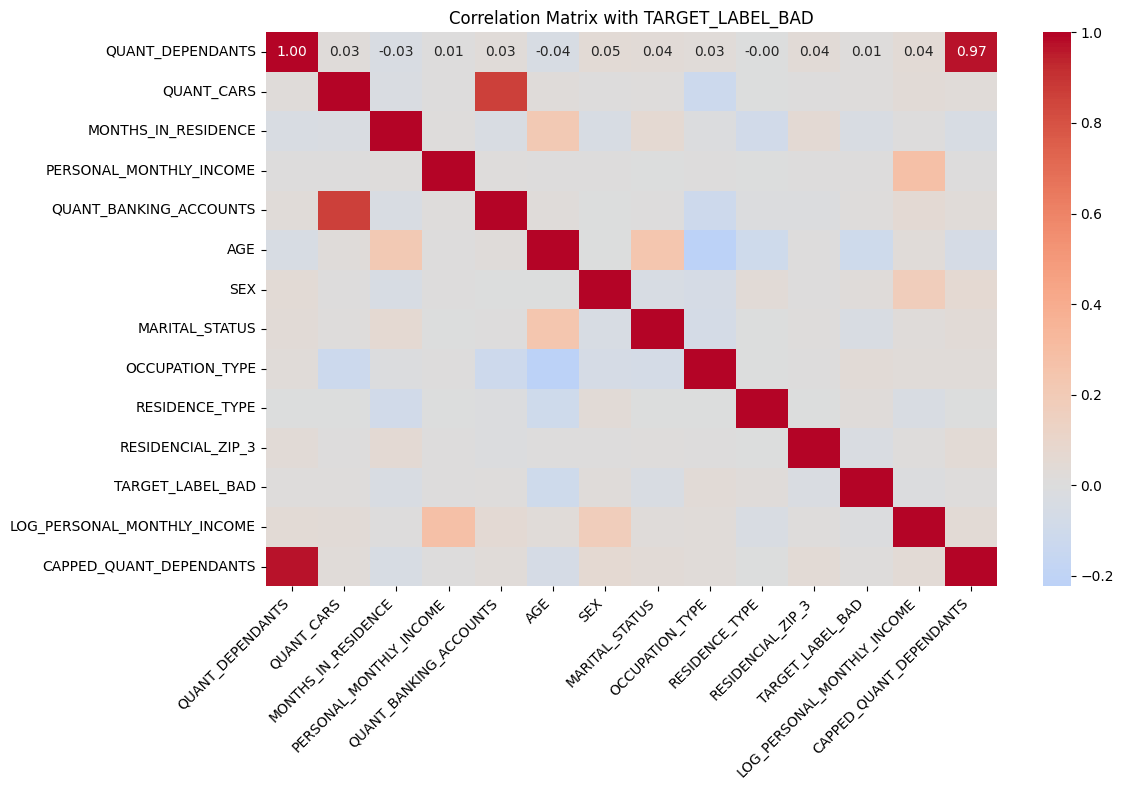

In [234]:
# Calculate the correlation matrix including the target variable
correlation_matrix = model_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix with TARGET_LABEL_BAD")
plt.xticks(rotation=45, ha="right")  # Improve readability of x labels
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [235]:
# Summary statistics for numerical columns
summary_stats = model_data.describe()

summary_stats

,QUANT_DEPENDANTS,QUANT_CARS,MONTHS_IN_RESIDENCE,PERSONAL_MONTHLY_INCOME,QUANT_BANKING_ACCOUNTS,AGE,SEX,MARITAL_STATUS,OCCUPATION_TYPE,RESIDENCE_TYPE,RESIDENCIAL_ZIP_3,TARGET_LABEL_BAD,LOG_PERSONAL_MONTHLY_INCOME,CAPPED_QUANT_DEPENDANTS
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.650520,0.336140,9.445600,886.678437,0.357840,43.24852,0.382600,2.14840,2.413480,1.24542,585.173300,0.260820,6.360347,0.636600
std,1.193655,0.472392,10.305137,7846.959327,0.479953,14.98905,0.486027,1.32285,1.426084,0.85702,227.779044,0.439086,0.618624,1.099675
min,0.000000,0.000000,0.000000,60.000000,0.000000,6.00000,0.000000,0.00000,0.000000,0.00000,105.000000,0.000000,4.110874,0.000000
25%,0.000000,0.000000,2.000000,360.000000,0.000000,31.00000,0.000000,1.00000,2.000000,1.00000,450.000000,0.000000,5.888878,0.000000
50%,0.000000,0.000000,6.000000,500.000000,0.000000,41.00000,0.000000,2.00000,2.000000,1.00000,600.000000,0.000000,6.216606,0.000000
75%,1.000000,1.000000,14.000000,800.000000,1.000000,53.00000,1.000000,2.00000,4.000000,1.00000,737.000000,1.000000,6.685861,1.000000
max,53.000000,1.000000,228.000000,959000.000000,2.000000,106.00000,1.000000,7.00000,5.000000,5.00000,999.000000,1.000000,13.773647,5.000000


## Model Fitting

### Exercise 5

First, use `train_test_split` to do an 80/20 split of your data. Then, using the `TARGET_LABEL_BAD` variable, fit a classification model on this data. Optimize with `gridsearch`. Use splines for continuous variables and factors for categoricals.

At this point we'd *ideally* be working with 11 variables. However pyGAM can get a little slow with factor features with lots of values + lots of unique values (e.g., 50,000 observations and the *many* values of `RESIDENCIAL_ZIP` takes about 15 minutes on my computer). In that configuration, you should get a model fit in 10-15 seconds.

So let's start by fitting a model that also excludes `RESIDENCIAL_ZIP`.

In [246]:
final_variables = [
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
 #   "RESIDENCIAL_ZIP_3",
    "LOG_PERSONAL_MONTHLY_INCOME",
    "CAPPED_QUANT_DEPENDANTS",
]

In [247]:
from sklearn.model_selection import train_test_split
from pygam import LogisticGAM, s, f

X = model_data[final_variables].values
y = model_data["TARGET_LABEL_BAD"].values

# Perform an 80/20 split of the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Get the index of X_train columns
for index, column in enumerate(final_variables):
    print(f"Index: {index}, Column: {column}")

Index: 0, Column: QUANT_CARS
Index: 1, Column: MONTHS_IN_RESIDENCE
Index: 2, Column: QUANT_BANKING_ACCOUNTS
Index: 3, Column: AGE
Index: 4, Column: SEX
Index: 5, Column: MARITAL_STATUS
Index: 6, Column: OCCUPATION_TYPE
Index: 7, Column: RESIDENCE_TYPE
Index: 8, Column: LOG_PERSONAL_MONTHLY_INCOME
Index: 9, Column: CAPPED_QUANT_DEPENDANTS


In [248]:
# Define the model with appropriate terms
gam = LogisticGAM(
    f(0)  # QUANT_CARS
    + s(1)  # MONTHS_IN_RESIDENCE
    + f(2)  # QUANT_BANKING_ACCOUNTS
    + s(3)  # AGE
    + f(4)  # SEX
    + f(5)  # MARITAL_STATUS
    + f(6)  # OCCUPATION_TYPE
    + f(7)  # RESIDENCE_TYPE
    + s(8)  # LOG_PERSONAL_MONTHLY_INCOME
    + f(9)  # CAPPED_QUANT_DEPENDANTS
).gridsearch(X_train, y_train)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:10 ETA:   0:01:41
 18% (2 of 11) |####                     | Elapsed Time: 0:00:16 ETA:   0:01:14
 27% (3 of 11) |######                   | Elapsed Time: 0:00:23 ETA:   0:01:03
 36% (4 of 11) |#########                | Elapsed Time: 0:00:29 ETA:   0:00:52
 45% (5 of 11) |###########              | Elapsed Time: 0:00:36 ETA:   0:00:44
 54% (6 of 11) |#############            | Elapsed Time: 0:00:43 ETA:   0:00:36
 63% (7 of 11) |###############          | Elapsed Time: 0:00:48 ETA:   0:00:27
 72% (8 of 11) |##################       | Elapsed Time: 0:00:54 ETA:   0:00:20
 81% (9 of 11) |####################     | Elapsed Time: 0:01:00 ETA:   0:00:13
 90% (10 of 11) |#####################   | Elapsed Time: 0:01:05 ETA:   0:00:06
100% (11 of 11) |########################| Elapsed Time: 0:01:09 Time:  0:01:09


### Exercise 6

Create a (naive) confusion matrix using the predicted values you get with `predict()` on your test data. Our stakeholder cares about two things: 

- maximizing the number of people to whom they extend credit, and
- the false negative rate (the share of people identified as "safe bets" who aren't, and who thus default).

How many "good bets" does the model predict (true negatives), and what is the [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives)?

Looking at the confusion matrix, how did the model maximize accuracy?

In [250]:
from sklearn.metrics import confusion_matrix

# Assuming y_pred contains the predicted values for the test set
y_pred = gam.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extracting TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate the false negative rate
FNR = FN / (FN + TP)
#  Calculate the false omission rate (FN / (FN + TN))
FOR = FN / (FN + TN)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Number of 'good bets' predicted (True Negatives): {TN}")
print(f"False Negative Rate: {FNR:.4f}")
print(f"False Omission Rate: {FOR:.4f}")

Confusion Matrix:
[[7331    5]
 [2658    6]]
Number of 'good bets' predicted (True Negatives): 7331
False Negative Rate: 0.9977
False Omission Rate: 0.2661


Based on the confusion matrix above, here's the interpretation regarding our stakeholder's concerns:

* The model predicted 7,331 'good bets' (True Negatives), meaning it classified this many instances correctly as safe to extend credit.
* The False Negative Rate (FNR) is 0.9977, indicating that all instances that should have been predicted as 'bad bets' (people who are not safe to extend credit to) were incorrectly predicted as 'good bets'. Essentially, the model failed to correctly identify any of the 'bad bets'.

* False Omission Rate (FOR): The FOR of 0.2661 suggests that more than a quarter of the instances predicted as 'good bets' are actually 'bad bets', further highlighting the risk in the model's predictions.

**How the model maximized accuracy:**

* The model maximized accuracy by predicting all instances as the majority class. This strategy often occurs in imbalanced datasets where one class significantly outnumbers the other. The model finds that always predicting the majority class (in this case, 'good bets') maximizes the overall number of correct predictions.

* While this approach maximizes the raw number of correct predictions, it fails to provide meaningful insights or useful predictions for the minority class (the 'bad bets'). This is a common issue in imbalanced classification problems and indicates that accuracy alone can be a misleading metric.

Given our stakeholder's concerns, this model is not achieving the desired outcome. Although it maximizes the number of people to whom credit is extended (by always predicting 'good bets'), it completely fails to identify any 'bad bets', making it unsafe from a credit risk perspective. The model, in its current state, does not provide a useful mechanism for distinguishing between safe and unsafe credit extensions.

### Exercise 7

Suppose your stakeholder wants to minimize false negative rates. How low of a [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives) can you get (assuming more than, say, 10 true negatives), and how many "good bets" (true negatives) do they get at that risk level?

Hint: use `predict_proba()`

Note: One *can* use class weights to shift the emphasis of the original model fitting, but for the moment let's just play with `predict_proba()` and thresholds.

In [259]:
# Get probabilities for the positive class
y_proba = gam.predict_proba(X_test)  # Directly use the output

# Initialize variables to track the best results
best_threshold = 0.5
lowest_fnr = 1.0
best_tn = 0

# Explore thresholds from 0.01 to 0.8
thresholds = np.linspace(0.01, 0.2, 100)

for threshold in thresholds:
    # Apply threshold to probabilities to make class predictions
    y_pred_threshold = (y_proba >= threshold).astype(int)

    # Calculate confusion matrix and extract TN, FN
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_threshold).ravel()

    # Calculate FNR
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0

    #  Calculate the false omission rate (FN / (FN + TN))
    FOR = FN / (FN + TN)
    # Update best results if FNR is lower and more than 10 TNs
    if FNR < lowest_fnr and TN > 10:
        lowest_fnr = FNR
        best_threshold = threshold
        best_tn = TN

# Display the best results
print(f"Best Threshold: {best_threshold}")
print(f"Lowest False Negative Rate: {lowest_fnr:.4f}")
print(f"Number of 'good bets' (True Negatives) at this level: {best_tn}")
print(f"False Omission Rate: {FOR:.4f}")

Best Threshold: 0.12707070707070708
Lowest False Negative Rate: 0.0011
Number of 'good bets' (True Negatives) at this level: 13
False Omission Rate: 0.1801


1. **Minimizing the False Omission Rate (FOR):** The lowest FOR we can achieve while meeting the condition of having more than 10 true negatives is approximately 0.1801. This indicates that, at the best threshold found, only about 18.01% of the instances predicted as 'good bets' (safe to extend credit to) are actually 'bad bets' (where credit should not have been extended). This is a significant improvement in minimizing the risk of extending credit to individuals likely to default.

2. **Number of 'Good Bets':** At this level of risk (FOR of 0.1801), the model predicts 13 'good bets'. This means that, according to the model's predictions at the optimal threshold, there are 13 instances where it is safe to extend credit under the updated model parameters.

### Exercise 8

If the stakeholder wants to maximize true negatives and can tolerate a false negative rate of 19%, how many true negatives will they be able to enroll?

In [260]:
# Get probabilities for the positive class
y_proba = gam.predict_proba(X_test)

# Initialize a variable to track the closest result to the desired FNR
closest_fnr = 1.0  # Start with the worst-case scenario
best_threshold = 0.5  # Default threshold
best_tn = 0  # To track the number of True Negatives at the best threshold

# Define the desired FNR
desired_fnr = 0.19

# Explore a range of thresholds
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    # Apply the threshold to make predictions
    y_pred_threshold = (y_proba >= threshold).astype(int)

    # Calculate the confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_threshold).ravel()

    # Calculate the current FNR
    current_fnr = FN / (FN + TP) if (FN + TP) > 0 else 0

    # Check if the current FNR is closer to the desired FNR than what we have seen so far
    if (
        abs(current_fnr - desired_fnr) < abs(closest_fnr - desired_fnr)
        and current_fnr <= desired_fnr
    ):
        closest_fnr = current_fnr
        best_threshold = threshold
        best_tn = TN

# Results
print(f"Best Threshold for desired FNR: {best_threshold}")
print(f"Closest FNR to desired: {closest_fnr:.4f}")
print(f"Number of True Negatives (Good Bets) at this threshold: {best_tn}")

Best Threshold for desired FNR: 0.21
Closest FNR to desired: 0.1715
Number of True Negatives (Good Bets) at this threshold: 2022


* The best threshold of 0.21 indicates that by adjusting the probability threshold for classifying 'good bets' versus 'bad bets', we were able to approach the stakeholder's tolerance for risk (an FNR of up to 19%) while ensuring a reasonable level of accuracy.

* Achieving an FNR of 17.15% means that the model incorrectly identifies approximately 17.15% of actual 'bad bets' as 'good bets'. This rate is below the maximum tolerance of 19% set by the stakeholder, indicating a satisfactory balance between risk management and credit extension opportunities.

* With 2022 true negatives, the model identifies 2022 instances where it is safe to extend credit under these adjusted parameters. This number represents the 'good bets' that the model has confidently identified, balancing the stakeholder's objectives of minimizing risk (keeping FNR below 19%) and maximizing the number of credit extensions.

## Let's See This Interpretability!

We're using GAMs for their interpretability, so let's use it!

### Exercise 9


Plot the partial dependence plots for all your continuous factors with 95% confidence intervals (I have three, at this stage).

If you get an error like this when generating `partial_dependence` errors:

```python
----> pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

...
ValueError: X data is out of domain for categorical feature 4. Expected data on [1.0, 2.0], but found data on [0.0, 0.0]
```

it's because you have a variable set as a factor that doesn't have values of `0`. pyGAM is assuming `0` is the excluded category. Just recode the variable to ensure 0 is used to identify one of the categories.

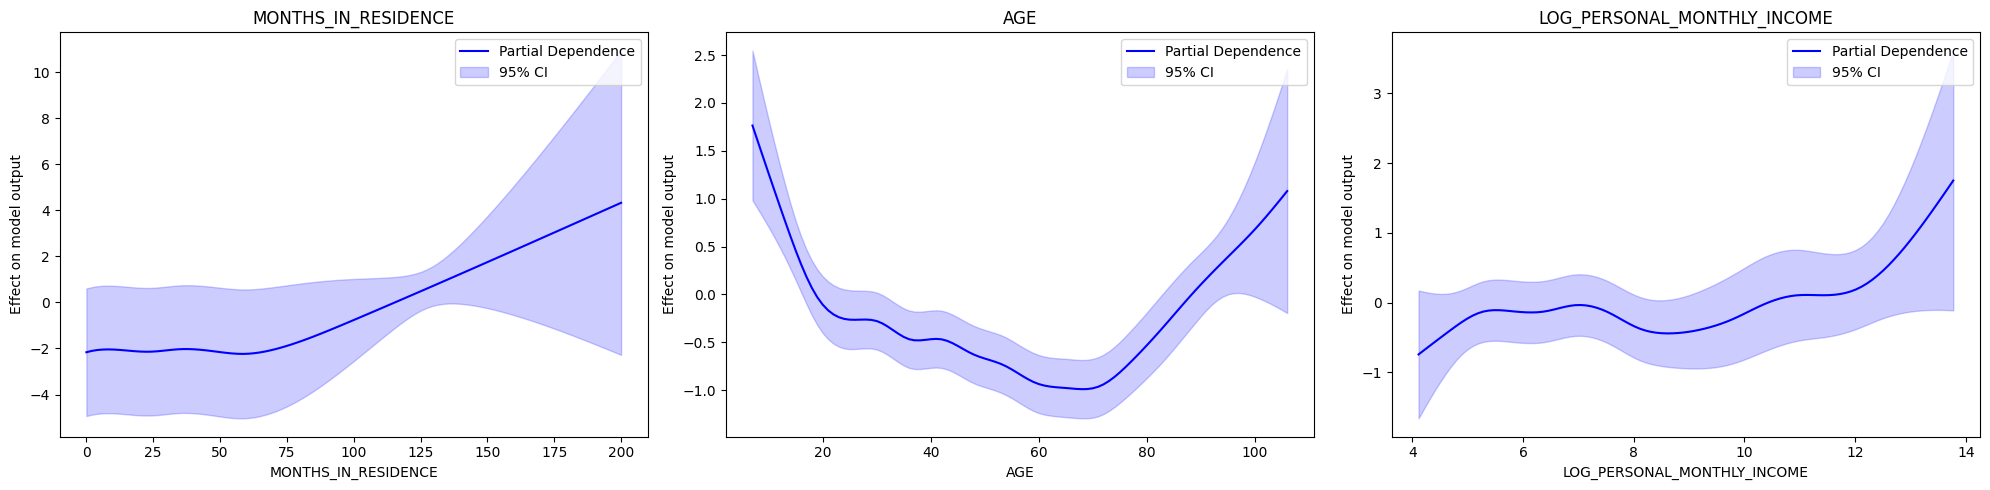

In [266]:
# Let's define indices for continuous features based on our setup
continuous_feature_indices = [1, 3, 8] 
feature_names = [
    "MONTHS_IN_RESIDENCE",
    "AGE",
    "LOG_PERSONAL_MONTHLY_INCOME",
]  

plt.figure(figsize=(20, 5))

for i, feature_index in enumerate(continuous_feature_indices):
    # Generate grid for a specific feature
    XX = gam.generate_X_grid(term=feature_index)

    # Calculate partial dependence and confidence intervals for the feature
    pdep, confi = gam.partial_dependence(term=feature_index, X=XX, width=0.95)

    # Plotting
    plt.subplot(1, len(continuous_feature_indices), i + 1)
    plt.plot(XX[:, feature_index], pdep, color="blue", label="Partial Dependence")
    plt.fill_between(
        XX[:, feature_index],
        confi[:, 0],
        confi[:, 1],
        color="blue",
        alpha=0.2,
        label="95% CI",
    )
    plt.title(feature_names[i])
    plt.xlabel(feature_names[i])
    plt.ylabel("Effect on model output")
    plt.legend()

plt.tight_layout()
plt.show()

### Exercise 10

How does the partial correlation with respect to age look?

The partial dependence plot for the variable `AGE` seems to show an interesting relationship with the model output:

* Starting from the younger ages, there's a steep decline in the model output effect, reaching a minimum at around mid-20s to early 30s.
* Following this minimum point, there's an increase in the effect on the model output as age increases, peaking somewhere around the mid-60s.
* After this peak, the effect starts to decline again but less steeply, suggesting that the oldest ages in the dataset have a lesser but still positive effect on the model output compared to middle-aged individuals.

This kind of pattern may suggest that mid-aged individuals are predicted to be safer bets compared to younger and much older individuals, according to the model. Additionally, the width of the 95% confidence intervals indicates more uncertainty in the model's predictions at the extremes of the age range, which is quite common since data for very young and very old individuals can be sparse.

### Exercise 11

Refit your model, but this time impose [monotonicity or concavity/convexity](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints) on the relationship between age and credit risk (which makes more sense to you?). Fit the model and plot the new partial dependence.

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:13 ETA:   0:02:11
 18% (2 of 11) |####                     | Elapsed Time: 0:00:20 ETA:   0:01:32
 27% (3 of 11) |######                   | Elapsed Time: 0:00:28 ETA:   0:01:14
 36% (4 of 11) |#########                | Elapsed Time: 0:00:35 ETA:   0:01:02
 45% (5 of 11) |###########              | Elapsed Time: 0:00:43 ETA:   0:00:52
 54% (6 of 11) |#############            | Elapsed Time: 0:00:51 ETA:   0:00:43
 63% (7 of 11) |###############          | Elapsed Time: 0:00:57 ETA:   0:00:33
 72% (8 of 11) |##################       | Elapsed Time: 0:01:05 ETA:   0:00:24
 81% (9 of 11) |####################     | Elapsed Time: 0:01:12 ETA:   0:00:16
 90% (10 of 11) |#####################   | Elapsed Time: 0:01:20 ETA:   0:00:08
100% (11 of 11) |########################| Elapsed Time: 0:01:26 Time:  0:01:26


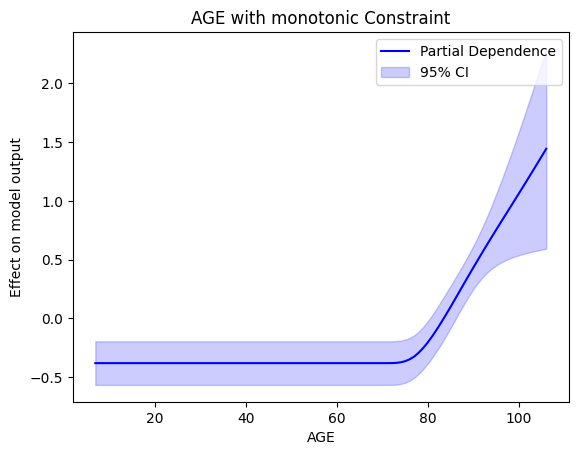

In [269]:
# Define the model with appropriate terms, imposing a monotonic constraint on the AGE term
gam_constrained = LogisticGAM(
    f(0)  # QUANT_CARS
    + s(1)  # MONTHS_IN_RESIDENCE
    + f(2)  # QUANT_BANKING_ACCOUNTS
    + s(3, constraints="monotonic_inc")  # AGE with monotonic constraint
    + f(4)  # SEX
    + f(5)  # MARITAL_STATUS
    + f(6)  # OCCUPATION_TYPE
    + f(7)  # RESIDENCE_TYPE
    + s(8)  # LOG_PERSONAL_MONTHLY_INCOME
    + f(9)  # CAPPED_QUANT_DEPENDANTS
).gridsearch(X_train, y_train)

# Now, let's plot the partial dependence for AGE with the new model
XX = gam_constrained.generate_X_grid(term=3)
pdep, confi = gam_constrained.partial_dependence(term=3, X=XX, width=0.95)

plt.figure()
plt.plot(XX[:, 3], pdep, color="blue", label="Partial Dependence")
plt.fill_between(
    XX[:, 3], confi[:, 0], confi[:, 1], alpha=0.2, color="blue", label="95% CI"
)
plt.title("AGE with monotonic Constraint")
plt.xlabel("AGE")
plt.ylabel("Effect on model output")
plt.legend()
plt.show()

The application of the monotonicity constraint shows that as age increases, the effect on the model's output initially stays relatively flat, but then begins to increase sharply after a certain age. This might reflect an assumption that credit risk decreases as individuals move past middle age into older age, perhaps due to factors like retirement savings kicking in, paying off mortgages, or other life events. The confidence intervals widen significantly for older ages, suggesting more uncertainty in the model's predictions for this segment of the population.

### Exercise 12

Functional form constraints are often about fairness or meeting regulatory requirements, but they can also prevent overfitting.

Does this change the number of "true negatives" you can enroll below a false negative rate of 19%?

In [270]:
# Get probabilities for the positive class
y_proba = gam_constrained.predict_proba(X_test)

# Initialize a variable to track the closest result to the desired FNR
closest_fnr = 1.0  # Start with the worst-case scenario
best_threshold = 0.5  # Default threshold
best_tn = 0  # To track the number of True Negatives at the best threshold

# Define the desired FNR
desired_fnr = 0.19

# Explore a range of thresholds
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    # Apply the threshold to make predictions
    y_pred_threshold = (y_proba >= threshold).astype(int)

    # Calculate the confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_threshold).ravel()

    # Calculate the current FNR
    current_fnr = FN / (FN + TP) if (FN + TP) > 0 else 0

    # Check if the current FNR is closer to the desired FNR than what we have seen so far
    if (
        abs(current_fnr - desired_fnr) < abs(closest_fnr - desired_fnr)
        and current_fnr <= desired_fnr
    ):
        closest_fnr = current_fnr
        best_threshold = threshold
        best_tn = TN

# Results
print(f"Best Threshold for desired FNR: {best_threshold}")
print(f"Closest FNR to desired: {closest_fnr:.4f}")
print(f"Number of True Negatives (Good Bets) at this threshold: {best_tn}")

Best Threshold for desired FNR: 0.22
Closest FNR to desired: 0.1614
Number of True Negatives (Good Bets) at this threshold: 1602


* The False Negative Rate (FNR) has decreased from 17.15% to 16.14%. This indicates an improvement in the model's ability to correctly identify 'bad bets'. The functional form constraint has likely made the model more conservative in predicting 'good bets', reducing the likelihood of false negatives.

* The number of True Negatives (TNs) has decreased from 2022 to 1602. This reduction in TNs means that while the model is now better at avoiding false negatives (hence the lower FNR), it is also predicting fewer 'good bets'. This could be a trade-off resulting from the more conservative nature of the model with the imposed constraints.

Imposing functional form constraints has resulted in a model that is better aligned with the stakeholder's tolerance for false negatives (below 19% FNR), but at the cost of reducing the number of opportunities for extending credit. This change reflects a shift towards a more cautious prediction model.

### Exercise 13

In the preceding exercises, we allowed pyGAM to choose its own smoothing parameters / coefficient penalties. This makes life easy, but it isn't always optimal, especially because when it does so, it picks the same smoothing penalty (the `lambda` in `.summary()`) for all terms.

(If you haven't seen them let, penalities are designed to limit overfitting by, basically, "penalizing" big coefficients on different terms. This tends to push models towards smoother fits.)

[To get around this, we can do a grid or random search.](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Automatically-tune-the-model) This is definitely a little slow, but let's give it a try!

Then following the model given in the docs linked above, let's do a random search. Make sure your initial random points has a shape of `100 x (the number of terms in your model)`.

In [273]:

# Define model with the terms
gam = LogisticGAM(
    f(0)  # QUANT_CARS
    + s(1)  # MONTHS_IN_RESIDENCE
    + f(2)  # QUANT_BANKING_ACCOUNTS
    + s(3)  # AGE
    + f(4)  # SEX
    + f(5)  # MARITAL_STATUS
    + f(6)  # OCCUPATION_TYPE
    + f(7)  # RESIDENCE_TYPE
    + s(8)  # LOG_PERSONAL_MONTHLY_INCOME
    + f(9)  # CAPPED_QUANT_DEPENDANTS
)

# Number of terms in our model
num_terms = len(gam.terms)

# Generate initial random points for lambda values
# Each term will have its own lambda value, and we need 100 sets of lambda values
initial_lam = (
    np.random.rand(100, num_terms) * 3 - 3
)  # This generates values between -3 and 0

# Scale them to be between 1e-3 and 1e3 because we want our lambdas to span 
# several orders of magnitude
initial_lam = 10**initial_lam

# Perform random search over the generated lambda values
gam.gridsearch(X_train, y_train, lam=initial_lam)

#Display the summary to see the results
gam.summary()

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:12 ETA:   0:20:52
  2% (2 of 100) |                        | Elapsed Time: 0:00:22 ETA:   0:18:24
  3% (3 of 100) |                        | Elapsed Time: 0:00:32 ETA:   0:17:27
  4% (4 of 100) |                        | Elapsed Time: 0:00:40 ETA:   0:16:08
  5% (5 of 100) |#                       | Elapsed Time: 0:00:48 ETA:   0:15:26
  6% (6 of 100) |#                       | Elapsed Time: 0:00:59 ETA:   0:15:26
  7% (7 of 100) |#                       | Elapsed Time: 0:01:07 ETA:   0:14:56
  8% (8 of 100) |#                       | Elapsed Time: 0:01:19 ETA:   0:15:12
  9% (9 of 100) |##                      | Elapsed Time: 0:01:29 ETA:   0:15:02
 10% (10 of 100) |##                     | Elapsed Time: 0:01:39 ETA:   0:14:57
 11% (11 of 100) |##                     | Elapsed Time: 0:01:48 ETA:   0:14:35
 12% (12 of 100) |##                    

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     56.4662
Link Function:                        LogitLink Log Likelihood:                                -22449.8438
Number of Samples:                        40000 AIC:                                            45012.6201
                                                AICc:                                           45012.7883
                                                UBRE:                                               3.1264
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0196
Feature Function                  Lam

### Exercise 15

How many true negatives can you get now at a less than 19% False Negative Rate?

In [274]:
# Get probabilities for the positive class
y_proba = gam.predict_proba(X_test)

# Initialize a variable to track the closest result to the desired FNR
closest_fnr = 1.0  # Start with the worst-case scenario
best_threshold = 0.5  # Default threshold
best_tn = 0  # To track the number of True Negatives at the best threshold

# Define the desired FNR
desired_fnr = 0.19

# Explore a range of thresholds
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    # Apply the threshold to make predictions
    y_pred_threshold = (y_proba >= threshold).astype(int)

    # Calculate the confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_threshold).ravel()

    # Calculate the current FNR
    current_fnr = FN / (FN + TP) if (FN + TP) > 0 else 0

    # Check if the current FNR is closer to the desired FNR than what we have seen so far
    if (
        abs(current_fnr - desired_fnr) < abs(closest_fnr - desired_fnr)
        and current_fnr <= desired_fnr
    ):
        closest_fnr = current_fnr
        best_threshold = threshold
        best_tn = TN

# Results
print(f"Best Threshold for desired FNR: {best_threshold}")
print(f"Closest FNR to desired: {closest_fnr:.4f}")
print(f"Number of True Negatives (Good Bets) at this threshold: {best_tn}")

Best Threshold for desired FNR: 0.21
Closest FNR to desired: 0.1768
Number of True Negatives (Good Bets) at this threshold: 2030


By tuning the smoothing parameters individually rather than using a single global smoothing parameter, we've been able to achieve a False Negative Rate (FNR) of 17.68%, which is below the desired maximum of 19%. At this threshold, our model predicts 2030 instances as 'good bets' where it is safe to extend credit.

It seems that the updated model with individually tuned smoothing parameters has allowed us to enroll slightly more 'good bets' while still keeping the FNR below the 19% threshold compared to previous iterations. This suggests that the model may have achieved a better balance between sensitivity and specificity, improving its ability to correctly identify 'good bets' without excessively raising the FNR.

The optimization process appears to have had a positive impact on the model's ability to meet the stakeholder's objectives, allowing for more credit opportunities without significantly increasing the risk of default.

### Exercise 16

Add an interaction term between age and personal income.

In [275]:
from pygam import LogisticGAM, s, f, te

# Define model with the terms, including the interaction term
gam = LogisticGAM(
    f(0)  # QUANT_CARS
    + s(1)  # MONTHS_IN_RESIDENCE
    + f(2)  # QUANT_BANKING_ACCOUNTS
    + s(3)  # AGE
    + f(4)  # SEX
    + f(5)  # MARITAL_STATUS
    + f(6)  # OCCUPATION_TYPE
    + f(7)  # RESIDENCE_TYPE
    + s(8)  # LOG_PERSONAL_MONTHLY_INCOME
    + f(9)  # CAPPED_QUANT_DEPENDANTS
    + te(3, 8)  # Interaction term between AGE and LOG_PERSONAL_MONTHLY_INCOME
)

# Fit the model
gam.gridsearch(X_train, y_train)

# After fitting, we can check the summary of the model
gam.summary()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:27 ETA:   0:04:32
 18% (2 of 11) |####                     | Elapsed Time: 0:00:41 ETA:   0:03:05
 27% (3 of 11) |######                   | Elapsed Time: 0:01:00 ETA:   0:02:40
 36% (4 of 11) |#########                | Elapsed Time: 0:01:24 ETA:   0:02:27
 45% (5 of 11) |###########              | Elapsed Time: 0:01:41 ETA:   0:02:02
 54% (6 of 11) |#############            | Elapsed Time: 0:01:57 ETA:   0:01:37
 63% (7 of 11) |###############          | Elapsed Time: 0:02:17 ETA:   0:01:18
 72% (8 of 11) |##################       | Elapsed Time: 0:02:47 ETA:   0:01:02
 81% (9 of 11) |####################     | Elapsed Time: 0:03:24 ETA:   0:00:45
 90% (10 of 11) |#####################   | Elapsed Time: 0:03:54 ETA:   0:00:23
100% (11 of 11) |########################| Elapsed Time: 0:04:19 Time:  0:04:19


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     52.6013
Link Function:                        LogitLink Log Likelihood:                                -22433.7408
Number of Samples:                        40000 AIC:                                            44972.6844
                                                AICc:                                           44972.8309
                                                UBRE:                                               3.1254
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0203
Feature Function                  Lam

### Exercise 17

Now visualize the [partial dependence interaction term.](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Terms-and-Interactions)

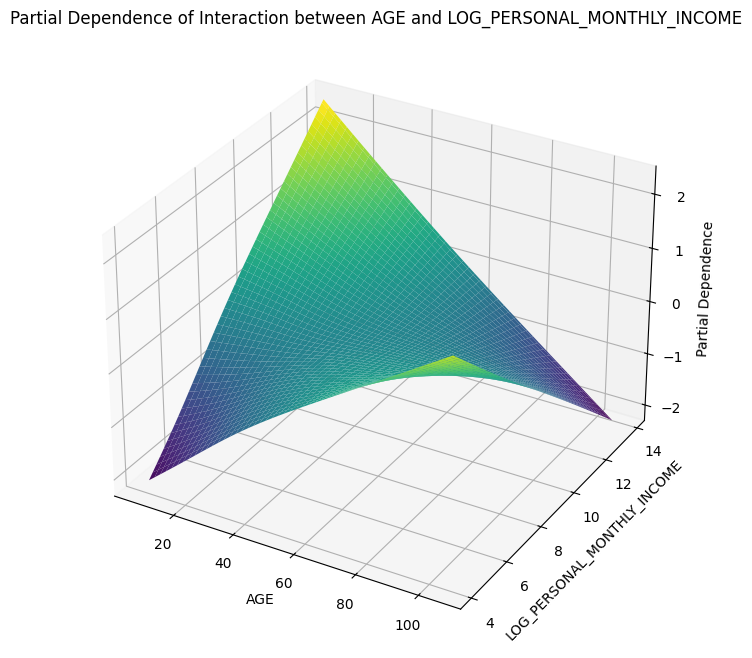

In [284]:
# # Get the interaction term index
# int_term_index = len(gam.terms) - 1

# # Generate grid for partial dependence for the interaction term
# XX = gam.generate_X_grid(term=int_term_index)

# # Calculate the partial dependence for the interaction term
# pdep, confi = gam.partial_dependence(term=int_term_index, X=XX, width=0.95)

# # Since the interaction term is a two-dimensional surface, we need to reshape
# # pdep and confi to the grid we created.
# # The shape should be the square root of the pdep size (assuming a square grid)
# grid_size = int(np.sqrt(len(pdep)))
# pdep = pdep.reshape((grid_size, grid_size))
# confi = confi.reshape((grid_size, grid_size, 2))

# # Create the plot
# fig, ax = plt.subplots(figsize=(10, 8))

# # Make a contour plot
# # The indices 3 and 8 correspond to the positions of the AGE and
# # LOG_PERSONAL_MONTHLY_INCOME features
# # in our design matrix (X_train)
# X_age, X_income = np.meshgrid(XX[:, 3], XX[:, 8])
# contour = ax.contourf(X_age, X_income, pdep, 20, cmap="coolwarm", alpha=0.5)

# # Add a color bar
# cbar = plt.colorbar(contour)
# cbar.ax.set_ylabel("Effect on model output")

# # Add labels and title
# ax.set_xlabel("AGE")
# ax.set_ylabel("LOG_PERSONAL_MONTHLY_INCOME")
# ax.set_title("Interaction between AGE and LOG_PERSONAL_MONTHLY_INCOME")

# # Show the plot
# plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

plt.ion()
plt.rcParams["figure.figsize"] = (12, 8)

XX = gam.generate_X_grid(term=10, meshgrid=True)
Z = gam.partial_dependence(term=10, X=XX, meshgrid=True)

ax = plt.axes(projection="3d")
surf = ax.plot_surface(XX[0], XX[1], Z, cmap="viridis")
# Add labels and title
ax.set_xlabel("AGE")  # Adjust if necessary
ax.set_ylabel("LOG_PERSONAL_MONTHLY_INCOME")  # Adjust if necessary
ax.set_zlabel("Partial Dependence")
ax.set_title(
    "Partial Dependence of Interaction between AGE and LOG_PERSONAL_MONTHLY_INCOME"
)

# Show the plot
plt.show()

### Exercise 18

Finally, another popular interpretable model is the `ExplainableBoostingClassifier`. You can learn more [about it here](https://interpret.ml/docs/ebm.html), though how much sense it will make to you may be limited if you aren't familiar with gradient boosting yet. Still, at least one of your classmates prefers it to pyGAM, so give it a try using this code:


```python
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")

   ebm_global = ebm.explain_global()
   show(ebm_global)

   ebm_local = ebm.explain_local(X_train, y_train)
   show(ebm_local)
```

In [285]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")

   ebm_global = ebm.explain_global()
   show(ebm_global)

   ebm_local = ebm.explain_local(X_train, y_train)
   show(ebm_local)

<!-- http://127.0.0.1:7001/2553890757264/ -->

<!-- http://127.0.0.1:7001/2555327721040/ -->